In [1]:
# ===== Imports =====
# System & File
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data processing & metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Image augmentations
import albumentations as A

# Hugging Face Transformers
!pip install -q transformers accelerate decord
from transformers import AutoModelForVideoClassification, AutoImageProcessor


# ===== Paths & Parameters =====
DATASET_PATH = "/kaggle/input/shop-dataset/Shop DataSet"
OUTPUT_PATH = "/kaggle/working/processed_videos"
os.makedirs(OUTPUT_PATH, exist_ok=True)

CLASSES = {"non shop lifters": 0, "shop lifters": 1}
SEED = 42
FRAME_SIZE = (128, 128)
N_FRAMES = 16
BATCH_SIZE = 8
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Augmentations
augment = A.Compose([
    A.NoOp()
])


2025-08-15 10:43:44.787411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755254624.813624    2668 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755254624.821438    2668 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def sample_frames(video_path, n_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        raise ValueError(f"Video {video_path} has no frames.")

    # Uniform frame selection
    if total_frames >= n_frames:
        indices = np.linspace(0, total_frames - 1, n_frames, dtype=int)
    else:
        indices = np.linspace(0, total_frames - 1, total_frames, dtype=int)
        indices = np.pad(indices, (0, n_frames - total_frames), mode='edge')

    frames = []
    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id in indices:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, FRAME_SIZE)
            frames.append(frame)
        frame_id += 1

    cap.release()

    frames = np.array(frames)
    if len(frames) < n_frames:  # pad if too short
        pad_count = n_frames - len(frames)
        frames = np.concatenate(
            [frames, np.repeat(frames[-1][None, ...], pad_count, axis=0)],
            axis=0
        )

    return frames


# Process and save frames as .npy
for label in os.listdir(DATASET_PATH):
    class_folder = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(class_folder):
        continue

    output_class_folder = os.path.join(OUTPUT_PATH, label)
    os.makedirs(output_class_folder, exist_ok=True)

    for filename in os.listdir(class_folder):
        if filename.lower().endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(class_folder, filename)
            try:
                frames = sample_frames(video_path, N_FRAMES)
                save_name = os.path.splitext(filename)[0] + ".npy"
                np.save(os.path.join(output_class_folder, save_name), frames)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

print("Preprocessing complete. Files saved in:", OUTPUT_PATH)


Preprocessing complete. Files saved in: /kaggle/working/processed_videos


In [2]:
# Collect all file paths and labels
all_paths = []
all_labels = []

for class_name, label in CLASSES.items():
    folder_path = os.path.join(OUTPUT_PATH, class_name)
    for fname in os.listdir(folder_path):
        if fname.endswith('.npy'):
            all_paths.append(os.path.join(folder_path, fname))
            all_labels.append(label)

print(f"Total files: {len(all_paths)}, Labels: {len(all_labels)}")


Total files: 637, Labels: 637


In [3]:
class VideoDataset(Dataset):
    def __init__(self, data_pairs, processor, transform=None):
        self.data_pairs = data_pairs
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        video_path, label = self.data_pairs[idx]
        video = np.load(video_path)  # (T, H, W, C)
        frames = [Image.fromarray(frame) for frame in video]

        if self.transform:
            frames = [
                Image.fromarray(self.transform(image=np.array(f))["image"])
                for f in frames
            ]

        inputs = self.processor(frames, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, torch.tensor(label, dtype=torch.long)


In [9]:
data_pairs = list(zip(all_paths, all_labels))

train_data, val_data = train_test_split(
    data_pairs, test_size=0.2, random_state=SEED, stratify=all_labels
)

# Processor for the model
MODEL_NAME = "MCG-NJU/videomae-small-finetuned-kinetics"
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

train_dataset = VideoDataset(train_data, processor, transform=augment)
val_dataset = VideoDataset(val_data, processor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [10]:
model = AutoModelForVideoClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(CLASSES),
    ignore_mismatched_sizes=True
).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-small-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
best_val_loss = float("inf") 

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            labels = labels.to(DEVICE)

            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    acc = accuracy_score(targets, preds)
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f}")

    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")


Epoch 1/50 | Train Loss: 0.3005 | Val Loss: 0.1002 | Val Acc: 0.9531
✅ Best model saved at epoch 1 (Val Loss: 0.1002)
Epoch 2/50 | Train Loss: 0.0837 | Val Loss: 0.1136 | Val Acc: 0.9531
Epoch 3/50 | Train Loss: 0.0411 | Val Loss: 0.0226 | Val Acc: 0.9844
✅ Best model saved at epoch 3 (Val Loss: 0.0226)
Epoch 4/50 | Train Loss: 0.0105 | Val Loss: 0.0036 | Val Acc: 1.0000
✅ Best model saved at epoch 4 (Val Loss: 0.0036)
Epoch 5/50 | Train Loss: 0.0349 | Val Loss: 0.0169 | Val Acc: 0.9922
Epoch 6/50 | Train Loss: 0.0636 | Val Loss: 0.0086 | Val Acc: 1.0000
Epoch 7/50 | Train Loss: 0.0031 | Val Loss: 0.0023 | Val Acc: 1.0000
✅ Best model saved at epoch 7 (Val Loss: 0.0023)
Epoch 8/50 | Train Loss: 0.0012 | Val Loss: 0.0017 | Val Acc: 1.0000
✅ Best model saved at epoch 8 (Val Loss: 0.0017)
Epoch 9/50 | Train Loss: 0.0009 | Val Loss: 0.0014 | Val Acc: 1.0000
✅ Best model saved at epoch 9 (Val Loss: 0.0014)
Epoch 10/50 | Train Loss: 0.0007 | Val Loss: 0.0011 | Val Acc: 1.0000
✅ Best model sa


Classification Report:
                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00        63
    shop lifters       1.00      1.00      1.00        65

        accuracy                           1.00       128
       macro avg       1.00      1.00      1.00       128
    weighted avg       1.00      1.00      1.00       128



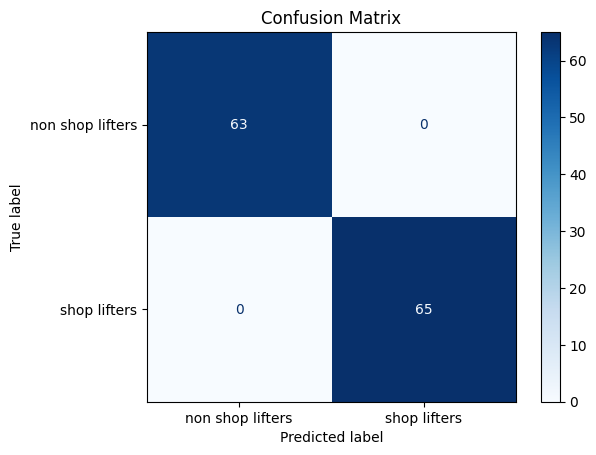

In [12]:
def evaluate_model(model, dataloader, device, best_model_path="best_model.pth"):
    # Load best saved weights
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES.keys()))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES.keys())
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation on the best model
evaluate_model(model, val_loader, DEVICE)
